RNN_2
这里是用前60min预测之后连续的30min。
【next】：预测后4h的15min；
另外，发现预测短期的结果很不错，但是时间越长越不行，考虑：
【next】：把预测得到的结果重新作为输入，接着预测下面的。

https://keras-cn.readthedocs.io/en/latest/getting_started/functional_API/
keras中文文档


In [1]:
# -*- coding: utf-8 -*-
#coding:unicode_escape
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文标签
plt.rcParams['axes.unicode_minus'] = False#解决负数问题

In [2]:
df = pd.read_csv("C:/Users/24496/Desktop/BigData/wind_raw.csv",encoding='unicode_escape')
df = df[['date','power','speed','day']]
df

,date,power,speed,day
0,2015/10/1 0:00,0.38065,0.39627,1
1,2015/10/1 0:00,0.36943,0.39592,1
2,2015/10/1 0:01,0.38529,0.39538,1
3,2015/10/1 0:01,0.38892,0.39579,1
4,2015/10/1 0:02,0.41220,0.39627,1
...,...,...,...,...
89275,2015/10/31 23:57,0.10177,0.27803,31
89276,2015/10/31 23:58,0.10354,0.27682,31
89277,2015/10/31 23:58,0.10008,0.27529,31
89278,2015/10/31 23:59,0.10516,0.27481,31


In [3]:
df_only_power = df[['power','speed']]
df_only_power


,power,speed
0,0.38065,0.39627
1,0.36943,0.39592
2,0.38529,0.39538
3,0.38892,0.39579
4,0.41220,0.39627
...,...,...
89275,0.10177,0.27803
89276,0.10354,0.27682
89277,0.10008,0.27529
89278,0.10516,0.27481


In [4]:
#使用前10天的数据做训练
df_train = df_only_power.iloc[:10*2880]
df_train
# df_train.isnull().values.any()   False

,power,speed
0,0.38065,0.39627
1,0.36943,0.39592
2,0.38529,0.39538
3,0.38892,0.39579
4,0.41220,0.39627
...,...,...
28795,0.53945,0.44130
28796,0.52914,0.44172
28797,0.53353,0.44153
28798,0.50544,0.44203


这里read_data和ANN_1不一样了。
改成，用之前N=30*2个数据预测后15min的数据

In [5]:
# import pandas as pd
# daaaa= pd.DataFrame([1,2,3,4,5,6,7,8,9,10])
# def read_data(N,P):  #N是特征数目，就是用之前多少个power来预测；P是预测未来多少min之后的

#     data = daaaa.values
#     X = []
#     Y = []
#     for i in range(N,len(data)-P):  #
#         # print("i:",i)
#         s=[]
#         for j in range(i-N,i):
#             # print(j)
#             s.append(data[j][0])
#             # print(s)
#         X.append(s)
#         t=[]
#         for k in range(i,i+P):   #Y是对未来的预测，预测的是好几个数值，现在是之后P/2分钟的结果。
#             t.append(data[k][0])
#         Y.append(t)
#     print("X",X)
#     print(Y)

#     # return np.array(X),np.array(Y)
# read_data(3,2)

In [6]:

def read_data(N,P):  #N是特征数目，就是用之前多少个power来预测；P是预测未来多少min之后的

    data = df_train.values
    X = []
    Y = []
    for i in range(N,len(data)-P):  #
        # print("i:",i)
        s=[]
        for j in range(i-N,i):
            # print(j)
            s.append(data[j][0])
            s.append(data[j][1])
            # print(s)
        X.append(s)
        t=[]
        for k in range(i,i+P):   #Y是对未来的预测，预测的是好几个数值，现在是之后P/2分钟的结果。
            t.append(data[k][0])
        Y.append(t)
    # print("X",X)
    # print(Y)
    return np.array(X),np.array(Y)
N = 120
P = 60
x_train,y_train = read_data(N,P)

In [7]:
x_train

array([[0.38065, 0.39627, 0.36943, ..., 0.38963, 0.3596 , 0.38971],
       [0.36943, 0.39592, 0.38529, ..., 0.38971, 0.34383, 0.38884],
       [0.38529, 0.39538, 0.38892, ..., 0.38884, 0.34248, 0.38733],
       ...,
       [0.47548, 0.43159, 0.48501, ..., 0.418  , 0.47008, 0.42052],
       [0.48501, 0.43195, 0.48227, ..., 0.42052, 0.47062, 0.41977],
       [0.48227, 0.43115, 0.46544, ..., 0.41977, 0.47196, 0.42231]])

In [8]:
# def read_data(N,P):  #N是特征数目，就是用之前多少个power来预测；P是预测未来多少min之后的

#     data = df_train.values
#     X = []
#     Y = []
#     for i in range(N,len(data)-P):  #
#         s=[]
#         for j in range(i-N,i):
#             s.append(data[j][0])
#         X.append(s)
#         Y.append(data[i][0])

#     return np.array(X),np.array(Y)

# Nset = 30*2 #用前20min的power预测后一个i

# N= Nset  
# X,Y = read_data(N)
# X


In [9]:
x_train,x_test,y_train,y_test = train_test_split(x_train,y_train,test_size = 0.2)


In [10]:
y_test

array([[0.10532, 0.10767, 0.10604, ..., 0.143  , 0.14167, 0.14305],
       [0.08403, 0.08594, 0.08662, ..., 0.08148, 0.08197, 0.08198],
       [0.72818, 0.70982, 0.72643, ..., 0.71968, 0.67509, 0.71254],
       ...,
       [0.03688, 0.03513, 0.03352, ..., 0.02861, 0.0263 , 0.02244],
       [0.72828, 0.74387, 0.72715, ..., 0.75447, 0.75228, 0.77156],
       [0.1147 , 0.11189, 0.11151, ..., 0.11103, 0.10721, 0.10467]])

In [11]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN,LSTM


这个参数不错：
 初始化顺序模型
regressor = Sequential()
 
定义输入层及带5个神经元的隐藏层
regressor.add(SimpleRNN(units = 10, input_shape = (x_train.shape[1], 1)))
 定义线性的输出层
regressor.add(Dense(units = 60))
 模型编译：定义优化算法adam， 目标函数均方根MSE
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
 模型训练
history = regressor.fit(x_train, y_train, epochs = 100, batch_size = 300, validation_split=0.)
 
regressor.summary()

In [13]:
# 初始化顺序模型
regressor = Sequential()
 
# 定义输入层及带5个神经元的隐藏层
regressor.add(SimpleRNN(units = 15, input_shape = (x_train.shape[1], 1)))
# 定义线性的输出层
regressor.add(Dense(units = 60))
# 模型编译：定义优化算法adam， 目标函数均方根MSE
# regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
# # 模型训练
# history = regressor.fit(x_train, y_train, epochs = 80, batch_size = 250, validation_split=0.3)

# regressor.summary()

In [14]:
# regressor.save_weights('RNN_2.h5')
regressor.load_weights("C:/Users/24496/Desktop/大数据final版本/RNN_2.h5") 


In [15]:
# from keras.models import load_model
# model = load_model('RNN_2.h5')

In [16]:
# #模型结构，采用relu函数为激活函数，输入层为N个属性
# #下面为4层隐含层，每层的神经元个数依次为500，500，250，250
# #输入层对应N个属性
# N=120
# model = keras.Sequential([
#         keras.layers.Dense(500,activation='relu',input_shape=[N]),
#         keras.layers.Dense(500,activation='relu'),
#         keras.layers.Dense(250,activation='relu'),
#         keras.layers.Dense(250,activation='relu'),
#         keras.layers.Dense(250,activation='relu'),
#         keras.layers.Dense(P)])#最后输出为P个数据，也就是预测的值
# #定义损失函数loss，采用的优化器optimizer为Adam
# model.compile(loss='mean_squared_error',optimizer='Adam')
# history = model.fit(x_train,y_train,batch_size = 250,epochs=1000)   #训练epochs个批次，每个批次数据量为batch_size

In [17]:
# plt.plot(history.history['loss'],c='blue')    # 蓝色线训练集损失
# plt.plot(history.history['val_loss'],c='red') # 红色线验证集损失
# plt.show()

In [18]:
# loss= model.evaluate(x_train,y_train,verbose = 2)
# rmse = loss**0.5
# print("rmse ={}".format(rmse))

In [19]:
#使用第12天的数据做预测验证
df_test = df.iloc[1*2880:2*2880]
df_test
# df_test.isnull().values.any()

,date,power,speed,day
2880,2015/10/2 0:00,0.00915,0.18371,2
2881,2015/10/2 0:00,0.00864,0.18257,2
2882,2015/10/2 0:01,0.00627,0.18162,2
2883,2015/10/2 0:01,0.00664,0.18062,2
2884,2015/10/2 0:02,0.00648,0.17980,2
...,...,...,...,...
5755,2015/10/2 23:57,0.22594,0.33787,2
5756,2015/10/2 23:58,0.22907,0.33951,2
5757,2015/10/2 23:58,0.23524,0.33987,2
5758,2015/10/2 23:59,0.24595,0.34125,2


In [20]:
df_test_only_power = df_test[['power','speed']]
df_test_only_power

,power,speed
2880,0.00915,0.18371
2881,0.00864,0.18257
2882,0.00627,0.18162
2883,0.00664,0.18062
2884,0.00648,0.17980
...,...,...
5755,0.22594,0.33787
5756,0.22907,0.33951
5757,0.23524,0.33987
5758,0.24595,0.34125


In [21]:
# def read_data(N,P):  #N是特征数目，就是用之前多少个power来预测；P是预测未来多少min之后的

#     data = df_train.values
#     X = []
#     Y = []
#     for i in range(N,len(data)-P):  #
#         # print("i:",i)
#         s=[]
#         for j in range(i-N,i):
#             # print(j)
#             s.append(data[j][0])
#             # print(s)
#         X.append(s)
#         t=[]
#         for k in range(i,i+P):   #Y是对未来的预测，预测的是好几个数值，现在是之后P/2分钟的结果。
#             t.append(data[k][0])
#         Y.append(t)
#     # print("X",X)
#     # print(Y)
#     return np.array(X),np.array(Y)
# N = 120
# x_train,y_train = read_data(120,60)

In [22]:
def read_data_test(N,P):  #N是特征数目，就是用之前多少个power 来预测后一个i   现在这还是预测后一个i！！！

    data = df_test_only_power.values
    X = []
    Y = []
    for i in range(N,len(data)-P):  #
        # print("i:",i)
        s=[]
        for j in range(i-N,i):
            # print(j)
            s.append(data[j][0])
            s.append(data[j][1])
            # print(s)
        X.append(s)
        t=[]
        for k in range(i,i+P):   #Y是对未来的预测，预测的是好几个数值，现在是之后P/2分钟的结果。
            t.append(data[k][0])
        Y.append(t)

    return np.array(X),np.array(Y)
N=120
P=60
x_test, y_test_true = read_data_test(N,P)
len(y_test_true)



2700

In [23]:
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [24]:
#输出结果预测
y_test_predict=regressor.predict(x_test)
# print('预测结果为：',y_test_predict)

85/85 [==============================] - 1s 10ms/step


In [25]:
y_test_true

array([[0.00237, 0.00169, 0.00198, ..., 0.00042, 0.00042, 0.00042],
       [0.00169, 0.00198, 0.00175, ..., 0.00042, 0.00042, 0.00042],
       [0.00198, 0.00175, 0.00132, ..., 0.00042, 0.00042, 0.00042],
       ...,
       [0.1915 , 0.19359, 0.18257, ..., 0.22788, 0.22594, 0.22907],
       [0.19359, 0.18257, 0.18522, ..., 0.22594, 0.22907, 0.23524],
       [0.18257, 0.18522, 0.18464, ..., 0.22907, 0.23524, 0.24595]])

In [26]:
#模型评估
print('预测与实际差异RMSE:',(sum(pow((y_test_predict - y_test_true),2))/y_test_predict.shape[0])**0.5)

预测与实际差异RMSE: [0.00567705 0.00623187 0.00631891 0.0074485  0.00847588 0.00929942
 0.00958293 0.01097706 0.01066965 0.01161483 0.01177766 0.01229101
 0.01314271 0.01406443 0.01435663 0.01488078 0.01580226 0.01625708
 0.0167949  0.0173552  0.01800713 0.01869126 0.01915893 0.02028807
 0.02037066 0.02083967 0.02148105 0.02199853 0.02279142 0.02315781
 0.02414311 0.02410409 0.02462938 0.02517296 0.02554198 0.02616118
 0.02664719 0.02714302 0.02787945 0.02783877 0.02826129 0.02886722
 0.0292658  0.02950853 0.02983121 0.03029369 0.030607   0.03124599
 0.03139919 0.03161793 0.03199428 0.03257215 0.0327956  0.03297283
 0.03345607 0.03382964 0.03389601 0.03409858 0.03469171 0.03465623]


预测与实际差异RMSE: [0.00567705 0.00623187 0.00631891 0.0074485  0.00847588 0.00929942
 0.00958293 0.01097706 0.01066965 0.01161483 0.01177766 0.01229101
 0.01314271 0.01406443 0.01435663 0.01488078 0.01580226 0.01625708
 0.0167949  0.0173552  0.01800713 0.01869126 0.01915893 0.02028807
 0.02037066 0.02083967 0.02148105 0.02199853 0.02279142 0.02315781
 0.02414311 0.02410409 0.02462938 0.02517296 0.02554198 0.02616118
 0.02664719 0.02714302 0.02787945 0.02783877 0.02826129 0.02886722
 0.0292658  0.02950853 0.02983121 0.03029369 0.030607   0.03124599
 0.03139919 0.03161793 0.03199428 0.03257215 0.0327956  0.03297283
 0.03345607 0.03382964 0.03389601 0.03409858 0.03469171 0.03465623]


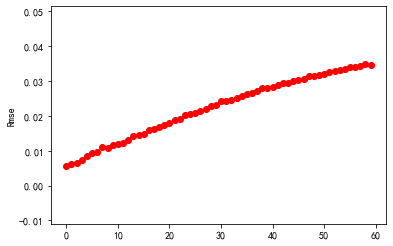

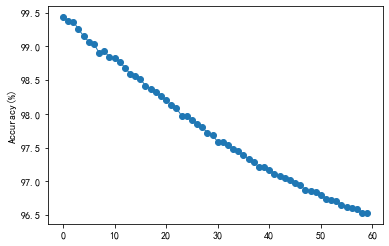

In [28]:
#模型评估
a = (sum(pow((y_test_predict - y_test_true),2))/y_test_predict.shape[0])**0.5
print('预测与实际差异RMSE:',a)
t = np.arange(len(a))
# plt.figure(figsize=(18,6))
plt.scatter(t,a,color = 'r')
plt.plot(t, a,"-",color='r', linewidth=1)
plt.ylabel('Rmse')

# plt.plot(t, y_test_predict[40], 'go-', linewidth=1, label='Predict')
# plt.legend()
plt.show()
tt = [1 for i in range(60)]
acc = (tt - a)*100
acc
plt.scatter(t,acc)
plt.plot(t, acc,"-", linewidth=1)
plt.ylabel('Accuracy(%)')
# plt.legend()
plt.show()
# print('预测与实际差异RMSE:',(sum(pow((y_test_predict - real_y),2))/y_test_predict.shape[0])**0.5)

In [ ]:
rmse=(sum(pow((y_test_predict - y_test_true),2))/y_test_predict.shape[0])**0.5


In [35]:

# t = np.arange(len(y_test_predict[4]))
# plt.figure(figsize=(18,6))
# plt.plot(t, y_test_true[40],"rs-", linewidth=1, label='Real')
# plt.plot(t, y_test_predict[40], 'go-', linewidth=1, label='Predict')
# plt.legend()
# plt.show()


In [30]:
len(y_test_predict)

2700

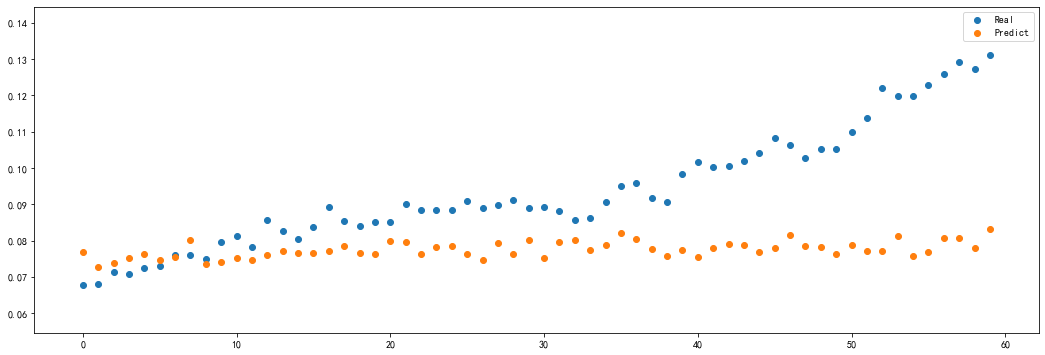

In [34]:
for i in range(7,8):
    t = np.arange(len(y_test_predict[i*60]))
    plt.figure(figsize=(18,6))
    # plt.plot(t, y_test_true[i*60],"rs-", linewidth=1, label='Real')

    # plt.plot(t, y_test_predict[i*60], 'go-', linewidth=1, label='Predict')
    plt.scatter(t, y_test_true[i*60], label='Real')
    plt.scatter(t, y_test_predict[i*60], label='Predict')
    plt.legend()
    plt.show()